In [ ]:
%pip install opencv-python-headless scikit-image

# FRA361: Fingernail disease prediction

## Import libraries

In [ ]:
# type: ignore

import cv2
import numpy as np
from sklearn.svm import SVC
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from skimage.io import imsave
from skimage import exposure
import glob

delete_folders_except function
1. Define parameters: get base_path, which is the base location where the function will run, and exclude_folder. This is the name of the directory that should not be deleted.

2. Open access to a directory or folder: Use os.scandir(base_path) to open access and read the directory or folder base_path.

3. Looping through all directories: Loop through all entries in base_path using the variables entries obtained from os.scandir().

4. Verify and delete directories or folders: For each entry, check whether the entry is a directory or not. (entry.is_dir())
and its name does not match exclude_folder. If both of these conditions are true, use shutil.rmtree(entry.path) to delete the directory and everything within that directory.

5. Printing deletion results: Displays a message telling you which directories were deleted by using print(f"Deleted {entry.path}")

## Import dataset.

In [ ]:
#Dataset folder path
base_path = '/content/dataset'
categories = ['Acral Lentiginous Melanoma', 'Koilonychia', 'Onychogryphosis', 'Terry-s nail']

In [ ]:
#to delete all directories in the specified base location (base_path), except for directories specified as not to be deleted. (exclude_folder)
def delete_folders_except(base_path, exclude_folder):
    with os.scandir(base_path) as entries:
        for entry in entries:
            # Check if it is a directory or not. And not a directory that wants to except
            if entry.is_dir() and entry.name != exclude_folder:
                # Delete directory and everything inside it.
                shutil.rmtree(entry.path)
                print(f"Deleted {entry.path}")

# Set Path for reading dataset
base_path = '/content'
exclude_folder = 'dataset'
delete_folders_except(base_path, exclude_folder)
delete_folders_except(base_path, 'dataset/')

## Image segmentation using region-based segmentation technique.

In [ ]:
#Region Growing Algorithm
def region_growing(img, seed, intensity_threshold):
    if img is None:
        raise ValueError("No image provided")

    if not (0 <= seed[0] < img.shape[0] and 0 <= seed[1] < img.shape[1]):
        raise ValueError("Seed point is outside the image bounds")

    connectivity = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # 4-way connectivity

    segmented_img = np.zeros_like(img, dtype=np.uint8)
    segmented_img[seed] = 255
    pixels = [seed]
    region_size = 1
    region_sum = int(img[seed])

    while pixels:
        new_pixels = []
        for pixel in pixels:
            for dx, dy in connectivity:
                x, y = pixel[0] + dx, pixel[1] + dy
                if 0 <= x < img.shape[0] and 0 <= y < img.shape[1]:
                    if segmented_img[x, y] == 0 and abs(int(img[x, y]) - region_sum / region_size) < intensity_threshold:
                        segmented_img[x, y] = 255
                        region_sum += int(img[x, y])
                        region_size += 1
                        new_pixels.append((x, y))
        pixels = new_pixels

    return segmented_img

In [ ]:
#function to create directory to store segmented images by classes
def setup_folders(base_path, categories):
    for category in categories:
        segmented_path = os.path.join(base_path, 'segmented_images', category)
        inverted_path = os.path.join(base_path, 'inverted_images', category)
        mask_path = os.path.join(base_path, 'mask_images', category)
        os.makedirs(segmented_path, exist_ok=True)
        os.makedirs(inverted_path, exist_ok=True)
        os.makedirs(mask_path, exist_ok=True)

segment_and_mask_images function

1. Looping through files in a folder: The function starts by looping through all files in the specified folder. (input_folder). The loop will only check files with an image extension (.png, .jpg, .jpeg).
2. Image reading and verification: For each file, the code reads the image file using cv2.imread() and checks whether the image reading is complete by checking for None.
3. Grayscale conversion: If the image reading is successful, the code converts the image to grayscale in preparation for the segmentation process.
4. Image segmentation: Use region_growing function. This is expected to be defined earlier in the code to segment grayscale images using the specified seed_point and intensity_threshold.
5. Generation of segmentation and inversion masks: The code generates two types of masks from the segmentation results.
   1. Segmentation mask: This is where the segmentation is identified as an area of interest. (segmented_img == 255).
   2. Inverted mask: Points that are not specified are areas of interest. (segmented_img != 255).

6. Creating Result Images: Use the created mask to create two result images from the original image converted to RGB:

   1. Segmented images: inverted_images
   2. Inverted images: segmented_images

7. Saving the resulting image: Save the created segmented and flipped image into the designated folder. (segmented_folder, inverted_folder) using cv2.imwrite with conversion back to BGR for compatibility with other programs that may use OpenCV.

In [ ]:
#Segmentation and create masks
def segment_and_mask_images(input_folder, segmented_folder, inverted_folder, mask_folder, seed_point, intensity_threshold):
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(input_folder, filename)
            original_image = cv2.imread(file_path)
            if original_image is None:
                continue

            gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
            segmented_img = region_growing(gray_image, seed_point, intensity_threshold)
            if segmented_img is None:
                continue

            RGB_img = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
            mask = segmented_img == 255
            inverted_mask = segmented_img != 255

            segmented_result = np.zeros_like(RGB_img)
            inverted_result = np.zeros_like(RGB_img)
            mask_result = np.zeros_like(RGB_img)  #create mask

            segmented_result[mask] = RGB_img[mask]
            inverted_result[inverted_mask] = RGB_img[inverted_mask]
            mask_result[mask] = 255

            # Save
            cv2.imwrite(os.path.join(segmented_folder, filename), cv2.cvtColor(segmented_result, cv2.COLOR_RGB2BGR))
            cv2.imwrite(os.path.join(inverted_folder, filename), cv2.cvtColor(inverted_result, cv2.COLOR_RGB2BGR))
            cv2.imwrite(os.path.join(mask_folder, filename), mask_result)

In [ ]:
setup_folders(base_path, categories)
for category in categories:
    input_folder = os.path.join(base_path, category)
    segmented_folder = os.path.join(base_path, 'segmented_images', category)
    inverted_folder = os.path.join(base_path, 'inverted_images', category)
    mask_folder = os.path.join(base_path, 'mask_images', category)
    # Choose Intensity_threshold as appropriate Which may be able to reference from the results above
    segment_and_mask_images(input_folder, segmented_folder, inverted_folder, mask_folder, (200, 200), 30)

## Feature extraction using Histogram of oriented gradients(HOG).

function extract_hog_features
1. Prepare folders: setup_folders function is called before the loop. This function creates base folders for storing segmented and inverted images according to the categories specified in categories. These folders are created under base_path for each category.
2. Looping through each category: The operation starts by looping through each category in categories to process the images according to category.
3. Set Folder Path: For each category, the code sets the path of the original image folder. (input_folder), folder for storing segmented images. (segmented_folder), and a folder for storing flipped images. (inverted_folder). These folders are created by category under base_path.
4. Process images in each category: Run the function segment_and_mask_images for each category using the folder path defined above. This function processes all images in input_folder, segment the image and create an inverted image, and save the results in segmented_folder and inverted_folder respectively.
5. Defining the slicing parameters: To run segment_and_mask_images, you specify seed_point (the starting point for the segmentation process) and intensity_threshold. (Intensity criteria used to decide which pixels should be segmented). These values are passed to the function. region_growing To control the division.

In [ ]:
#Extract Features by Hog Algorithm
def extract_hog_features(image_path, save_path=None):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None

    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True, feature_vector=True)
    if save_path:
        imsave(save_path, hog_image)
        print(f"HOG image saved at: {save_path}")
    return fd

## Training model using SVM model

prepare_data_for_svm function
1. Defining variables
2. Looping through base folders
3. Looping through categories
4. Looping through files in each category
5. HOG feature extraction and data collection
6. Returning data or sending values back

The algorithm divides the image into smaller segments and calculates the distribution of directional gradients of the pixels in each segment. Normalization is also performed. to adjust the gradients to ensure equality between the images and in the end you will get the HOG features of the image.

When finished calculating HOG features for all specified images. The function returns features , which are a list of each image's HOG features, and labels , which are a list of image category labels that correspond to the order of features in features .


The result returned is a matrix, where features are rows of individual image attributes, while labels are a list of category labels that correspond to each image in features.


Output example: array([0.11120968, 0.27166923, 0.17005313, ..., 0.01035615, 0.04108717, 0.00676854])

In [ ]:
def prepare_data_for_svm(base_paths, categories):
    features = []
    labels = []
    for base_path in base_paths:
        for category in categories:
            folder_path = os.path.join(base_path, category)
            for filename in os.listdir(folder_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_path = os.path.join(folder_path, filename)
                    fd = extract_hog_features(file_path)
                    if fd is not None:
                        features.append(fd)
                        labels.append(category)
    return features, labels

In [ ]:
class ImageProcessor:
    def __init__(self, segment_folder, inverted_folder, output_folder):
        self.segment_folder = segment_folder
        self.inverted_folder = inverted_folder
        self.output_folder = output_folder

    def compute_and_save_hog(self):
        if not os.path.exists(self.output_folder):
            os.makedirs(self.output_folder)

        for class_folder in os.listdir(self.segment_folder):
            class_segment_folder = os.path.join(self.segment_folder, class_folder)
            class_inverted_folder = os.path.join(self.inverted_folder, class_folder)
            class_output_folder = os.path.join(self.output_folder, class_folder)

            if not os.path.exists(class_output_folder):
                os.makedirs(class_output_folder)

            for file_path in glob.glob(os.path.join(class_segment_folder, '*.jpg')):
                image = cv2.imread(file_path, cv2.IMREAD_COLOR)
                if image is None:
                    print(f"Failed to load image: {file_path}")
                    continue

                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)

                hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

                hog_image_uint8 = (hog_image_rescaled * 255).astype(np.uint8)

                base_name = os.path.basename(file_path)
                output_image_path = os.path.join(class_output_folder, f"HOG_{base_name}")
                cv2.imwrite(output_image_path, hog_image_uint8)

                print(f"HOG image saved to: {output_image_path}")

In [ ]:
#define path of folder: segment, inverted
segmented_folder = '/content/dataset/segmented_images'
inverted_folder = '/content/dataset/inverted_images'
hog_output_folder = '/content/dataset/hog_output'

processor = ImageProcessor(segmented_folder, inverted_folder, hog_output_folder)
processor.compute_and_save_hog()

HOG image saved to: /content/dataset/hog_output/Onychogryphosis/HOG_Screenshot-2021-11-19-013411_png_jpg.rf.88b76dd394363e96fae2f5c770ddd8a8.jpg
HOG image saved to: /content/dataset/hog_output/Onychogryphosis/HOG_Screen-Shot-2021-11-16-at-10-50-37-PM_png_jpg.rf.38728be407251c0092403142ee7ef84f.jpg
HOG image saved to: /content/dataset/hog_output/Onychogryphosis/HOG_Screen-Shot-2021-11-16-at-10-23-59-PM_png_jpg.rf.a4cbd5796a0c2ec05f22bbf3aa5e0aa1.jpg
HOG image saved to: /content/dataset/hog_output/Onychogryphosis/HOG_images-bQXq51_jpeg_jpg.rf.13b4e4011731f3149b314011477cbd49.jpg
HOG image saved to: /content/dataset/hog_output/Onychogryphosis/HOG_Screen-Shot-2021-11-16-at-10-50-56-PM_png_jpg.rf.f2a3dae05d6515ab3f17dea048609485.jpg
HOG image saved to: /content/dataset/hog_output/Onychogryphosis/HOG_Screen-Shot-2021-11-16-at-10-43-22-PM_png_jpg.rf.2d9bf96eab765ddaf7f60a8e3b8a52eb.jpg
HOG image saved to: /content/dataset/hog_output/Onychogryphosis/HOG_Screen-Shot-2021-11-16-at-10-23-59-PM_pn

In [ ]:
def count_images_in_categories(base_path, categories):
    image_count = {}
    for category in categories:
        folder_path = os.path.join(base_path, category)
        count = 0
        # Check file in the folder
        for _, _, files in os.walk(folder_path):
            count += sum(1 for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg')))
        image_count[category] = count
    return image_count

In [ ]:
def plot_distribution(image_counts):
    categories = list(image_counts.keys())
    counts = list(image_counts.values())
    plt.figure(figsize=(10, 5))
    plt.bar(categories, counts, color='skyblue')
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Images Across Different Categories')
    plt.xticks(rotation=45)
    plt.show()

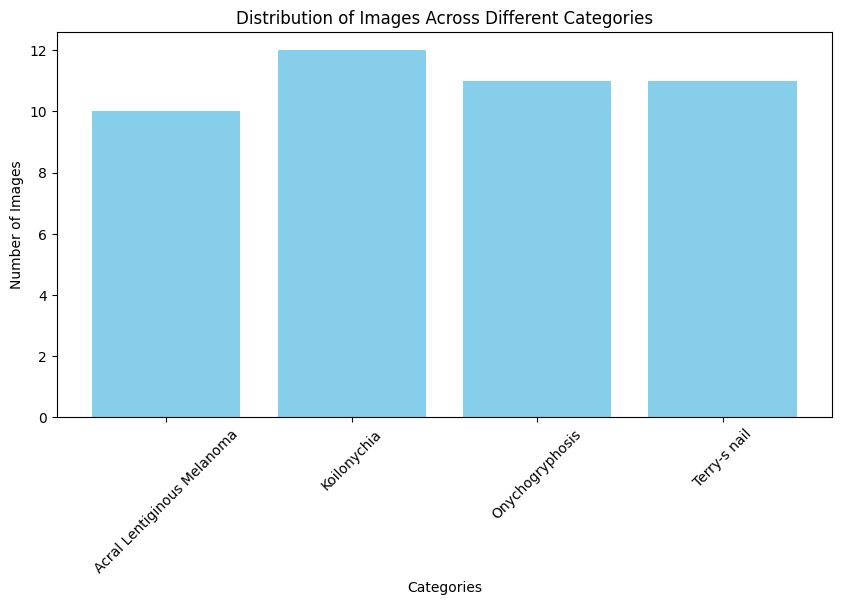

In [ ]:
image_counts = count_images_in_categories(base_path, categories)
plot_distribution(image_counts)

In [ ]:
base_paths = [
    '/content/dataset/inverted_images',
    '/content/dataset/segmented_images'
]
features, labels = prepare_data_for_svm(base_paths, categories)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

What does this graph indicate?
:This plot can help us see differences in visual characteristics between categories without needing to look at sample images. But we can look at the distribution of all HOG features in each category.

By understanding the differences in HOG features between categories, we can use the obtained HOG feature information to train the SVM model, so that the model can effectively learn and classify images.

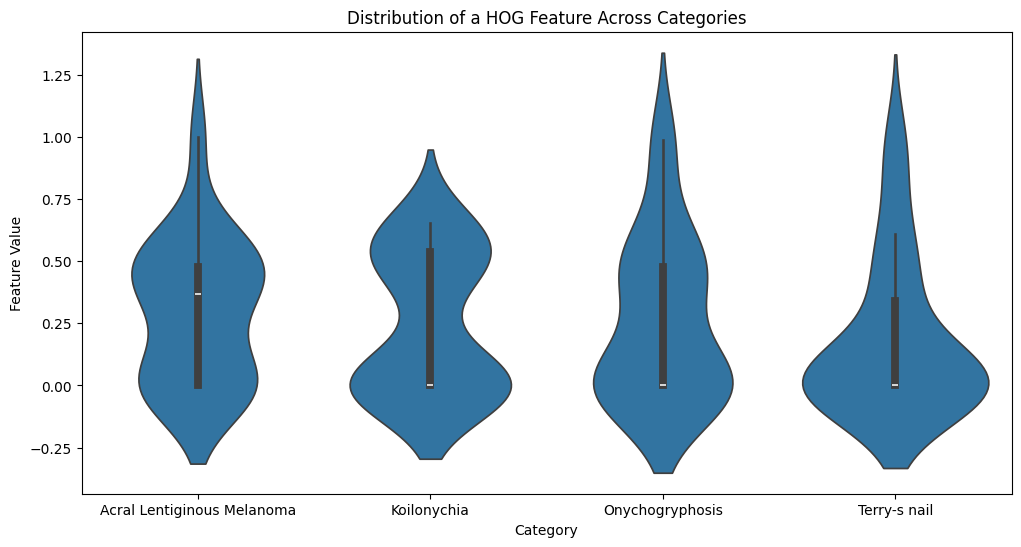

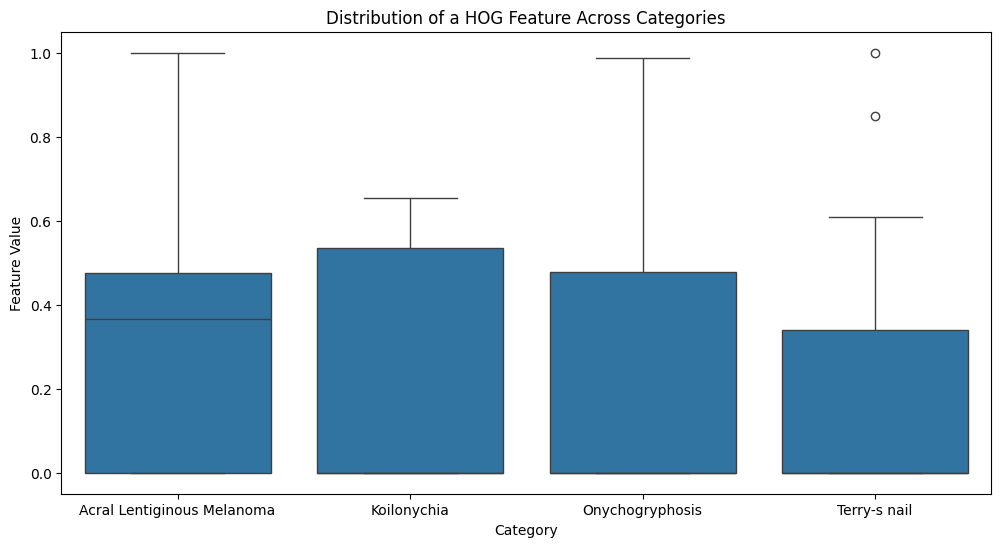

In [ ]:
df = pd.DataFrame(features)
df['label'] = labels
plt.figure(figsize=(12, 6))
sns.violinplot(x='label', y=0, data=df)
plt.title('Distribution of a HOG Feature Across Categories')
plt.xlabel('Category')
plt.ylabel('Feature Value')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y=0, data=df)
plt.title('Distribution of a HOG Feature Across Categories')
plt.xlabel('Category')
plt.ylabel('Feature Value')
plt.show()

In [ ]:
model = SVC(kernel='linear')
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

                            precision    recall  f1-score   support

Acral Lentiginous Melanoma       0.00      0.00      0.00         3
               Koilonychia       0.25      0.20      0.22         5
           Onychogryphosis       0.40      0.40      0.40         5
              Terry-s nail       0.25      0.20      0.22         5

                  accuracy                           0.22        18
                 macro avg       0.23      0.20      0.21        18
              weighted avg       0.25      0.22      0.23        18

